<a href="https://colab.research.google.com/github/Gk1694/Deep-Learning/blob/main/Skin_Cancer_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:59<00:00, 33.1MB/s]
100% 5.20G/5.20G [00:59<00:00, 93.9MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import shutil
import pandas as pd
from glob import glob
import numpy as np
import os
import PIL
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

In [ ]:
skin_df = pd.read_csv('/content/HAM10000_metadata.csv')

image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/content/','*','*.jpg'))}


In [ ]:
print(image_path['ISIC_0024345'])

/content/ham10000_images_part_1/ISIC_0024345.jpg


In [ ]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


# Exploratory Data Analysis

**Cell type affect on Patients**

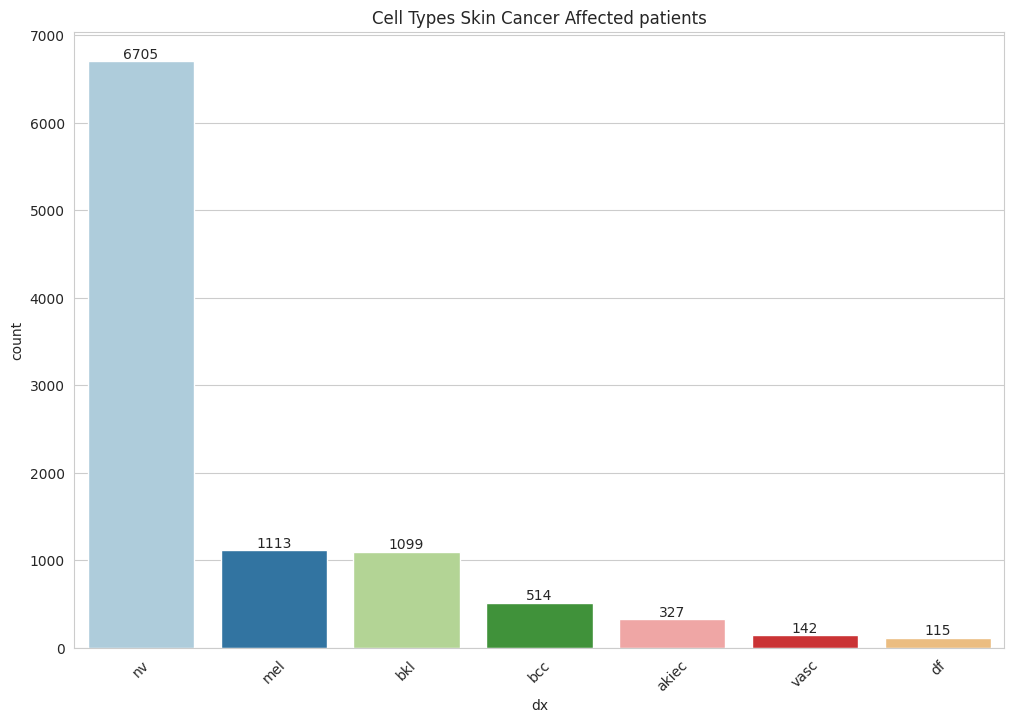

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',data=skin_df, order = skin_df['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

* Note
  * There are vast number of cases of Melanocytic nevi as compared to others.
  * Melanoma and Benign keratosis-like lesions are quite less wide spread as compared to Melanocytic nevi.
  * Other cell type viruses subsequently affected less in numbers.

**Gender vs Cell type.**

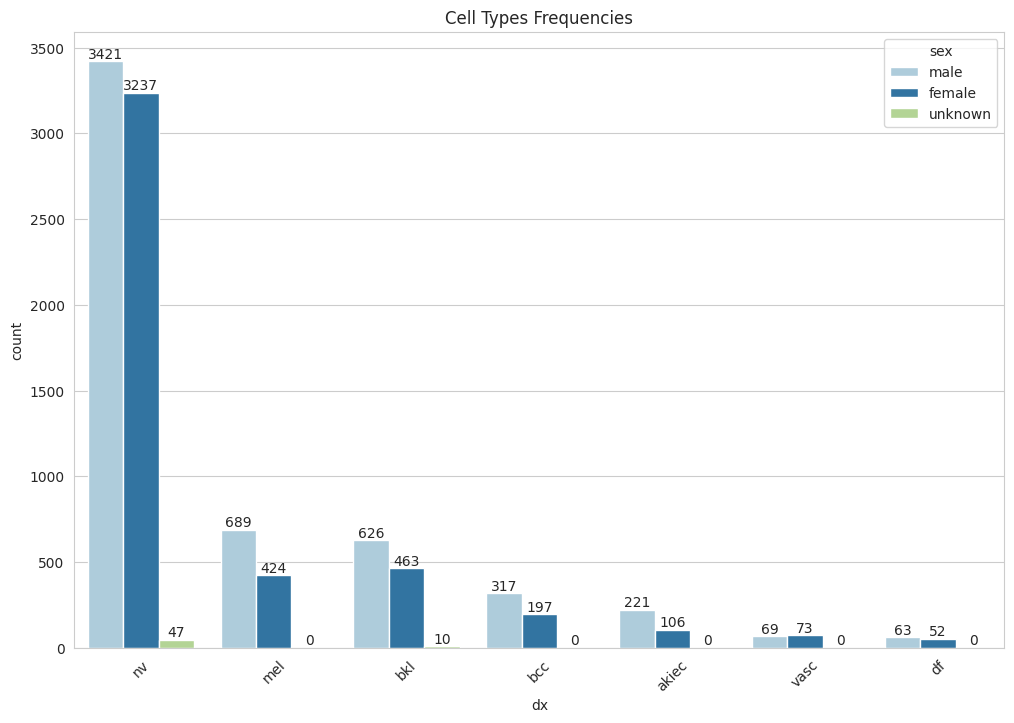

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=skin_df, order = skin_df['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

* Note:
  * It seems for every skin type cancer, majority of males are victims.

**Localization area**

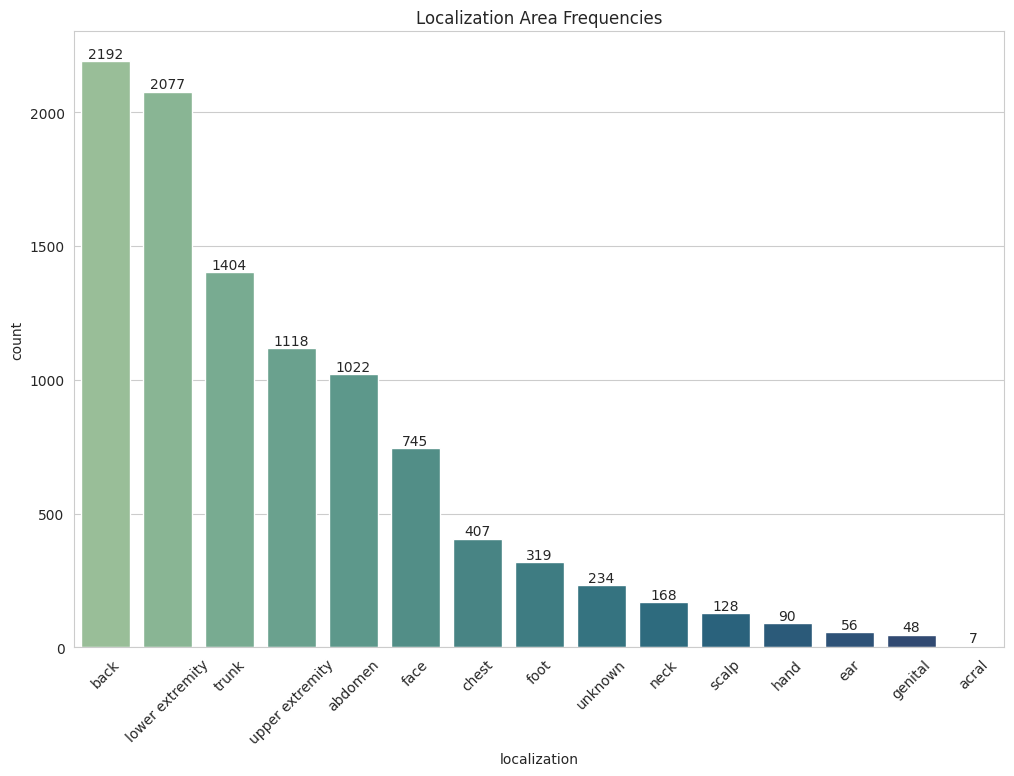

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

Notes:
  * It seems most of the area affected is related to particularly back, lower extremity or trunk etc.
  * The significance we take out of it as the areas where the part gets sweaty easily.

**Cell Type vs Age**

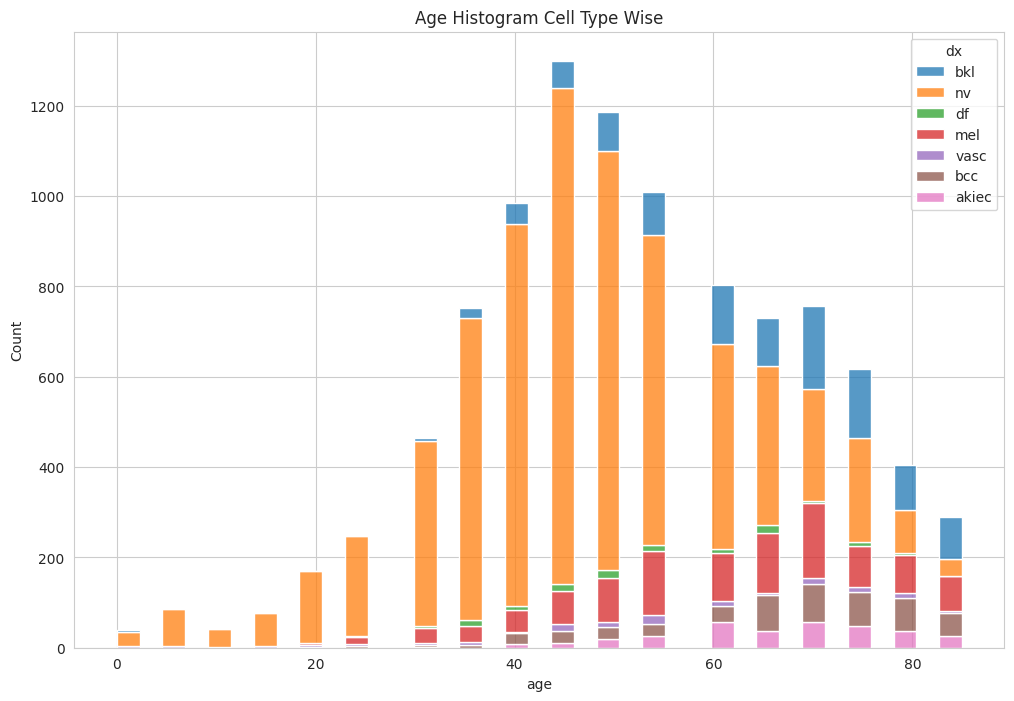

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=skin_df, x='age',hue='dx',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

# Data Preprocessing

In [ ]:
label = skin_df['dx'].unique().tolist()
label_images = []
print(label)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


In [ ]:
if not os.path.exists('data'):
        os.mkdir('data')

In [ ]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
grouped = skin_df.groupby('dx')

In [ ]:
selected_data = pd.DataFrame()

for group_name, group_df in grouped:
    # Select the specified number of samples from each group
    selected_samples = group_df.head(500)

    # Append the selected samples to the 'selected_data' DataFrame
    selected_data = selected_data.append(selected_samples)


In [ ]:
print(selected_data['dx'].value_counts())

bcc      500
bkl      500
mel      500
nv       500
akiec    327
vasc     142
df       115
Name: dx, dtype: int64


In [ ]:
for i in label:
    if not os.path.exists('/content/data/'+i+'/'):
        os.mkdir('/content/data/'+i+'/')
    sample = selected_data[selected_data['dx']==i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        src = image_path[id]
        #print(src)
        shutil.copyfile((src),('/content/data/'+i+'/'+id+'.jpg'))
    label_images = []

In [ ]:
class_subset = os.listdir('/content/data')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

# Load a Dataset
Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/data/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

Found 2584 files belonging to 7 classes.
Using 2068 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/data/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

Found 2584 files belonging to 7 classes.
Using 516 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 14
Number of test batches: 3


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


The image_batch is a tensor of the shape (32, 128, 128, 3). This is a batch of 32 images of shape 128x128x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

# Visualize the data
Here are the first 9 images in the training dataset.

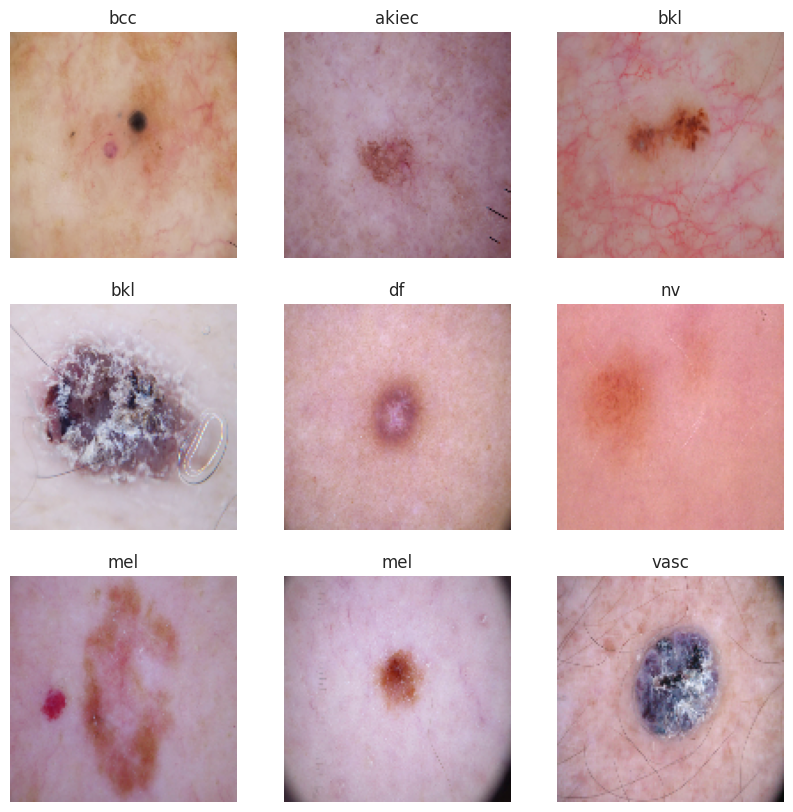

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:


*   Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
*   Dataset.prefetch overlaps data preprocessing and model execution while training.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.11271351 0.8903484


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here

# A basic Keras model
**Create the model**

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [ ]:
num_classes = len(class_names)

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

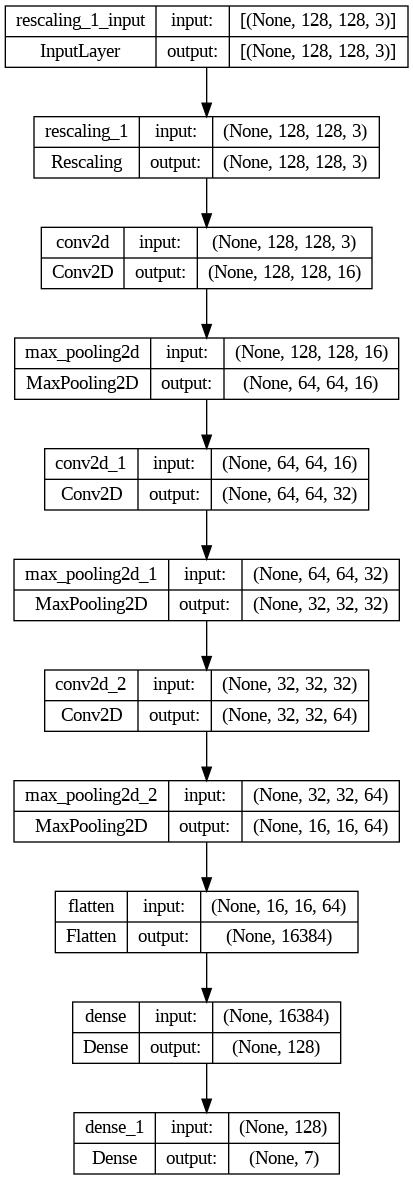

In [ ]:
keras.utils.plot_model(model_1, show_shapes=True)

**Compile the model**

 choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

View all the layers of the network using the Keras Model.summary method:

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

**Train the model**

Train the model for 10 epochs with the Keras Model.fit method

In [ ]:
epochs=10
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
65/65 [==============================] - 48s 715ms/step - loss: 1.6234 - accuracy: 0.3670 - val_loss: 1.4127 - val_accuracy: 0.4690
Epoch 2/10
65/65 [==============================] - 46s 715ms/step - loss: 1.2845 - accuracy: 0.5184 - val_loss: 1.2757 - val_accuracy: 0.5595
Epoch 3/10
65/65 [==============================] - 44s 673ms/step - loss: 1.0768 - accuracy: 0.6078 - val_loss: 1.1969 - val_accuracy: 0.5167
Epoch 4/10
65/65 [==============================] - 44s 671ms/step - loss: 0.9765 - accuracy: 0.6378 - val_loss: 1.1653 - val_accuracy: 0.5571
Epoch 5/10
65/65 [==============================] - 47s 726ms/step - loss: 0.9003 - accuracy: 0.6712 - val_loss: 1.0949 - val_accuracy: 0.5667
Epoch 6/10
65/65 [==============================] - 44s 673ms/step - loss: 0.8480 - accuracy: 0.6910 - val_loss: 1.0009 - val_accuracy: 0.6048
Epoch 7/10
65/65 [==============================] - 43s 659ms/step - loss: 0.7646 - accuracy: 0.7220 - val_loss: 0.9914 - val_accuracy: 0.6024

**Visualize training results**

Create plots of the loss and accuracy on the training and validation sets:

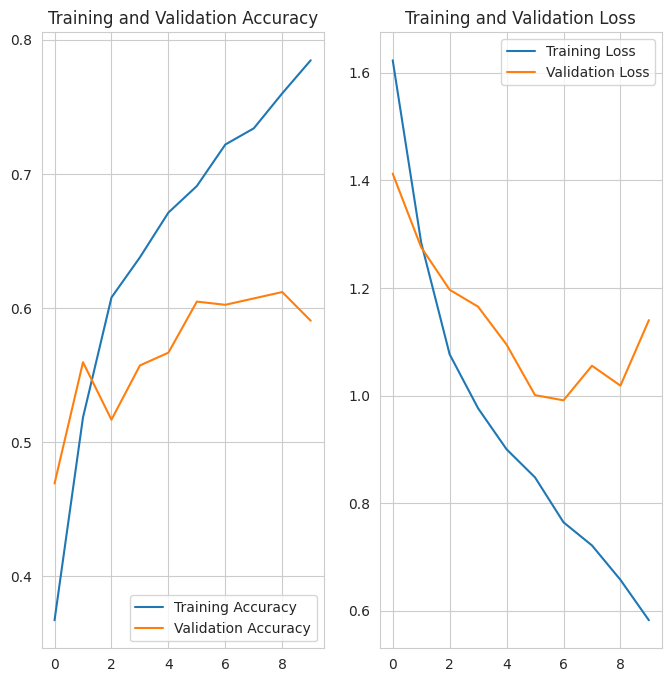

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

# Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(128,
                                  128,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset

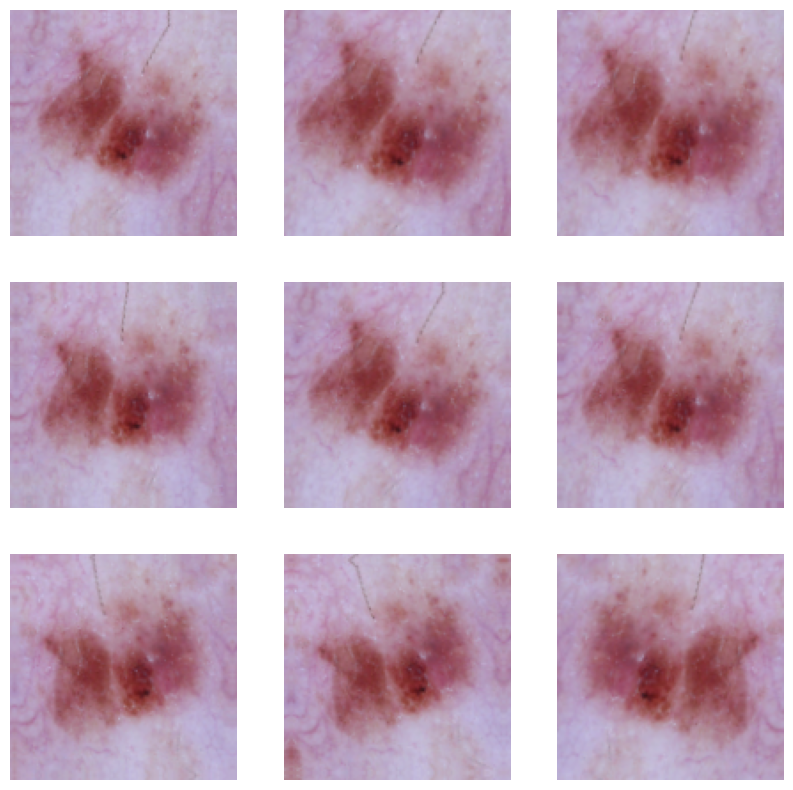

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

**Dropout**

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [ ]:
model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

**Compile and train the model**

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
65/65 [==============================] - 53s 790ms/step - loss: 1.6623 - accuracy: 0.3496 - val_loss: 1.5638 - val_accuracy: 0.3881
Epoch 2/15
65/65 [==============================] - 49s 759ms/step - loss: 1.4273 - accuracy: 0.4507 - val_loss: 1.3019 - val_accuracy: 0.4786
Epoch 3/15
65/65 [==============================] - 49s 761ms/step - loss: 1.3250 - accuracy: 0.4903 - val_loss: 1.3637 - val_accuracy: 0.4452
Epoch 4/15
65/65 [==============================] - 50s 764ms/step - loss: 1.2226 - accuracy: 0.5314 - val_loss: 1.2994 - val_accuracy: 0.4833
Epoch 5/15
65/65 [==============================] - 55s 854ms/step - loss: 1.1659 - accuracy: 0.5435 - val_loss: 1.1907 - val_accuracy: 0.5333
Epoch 6/15
65/65 [==============================] - 49s 750ms/step - loss: 1.0730 - accuracy: 0.5909 - val_loss: 1.0852 - val_accuracy: 0.5690
Epoch 7/15
65/65 [==============================] - 50s 769ms/step - loss: 1.0416 - accuracy: 0.5953 - val_loss: 1.0609 - val_accuracy: 0.5571

**Visualize training results**

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

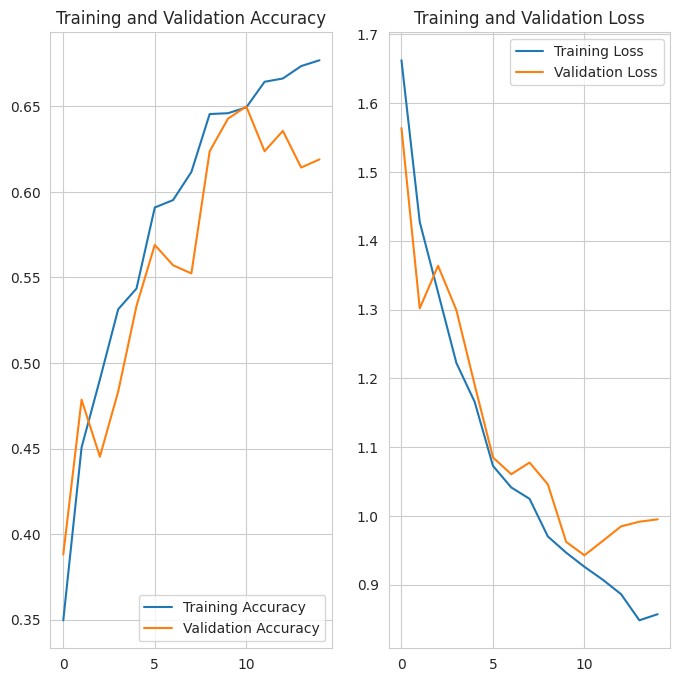

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Evaluate the model on test data**

In [ ]:
score = model_2.evaluate(test_ds)
print('Test accuracy:', score[1])

3/3 [==============================] - 4s 322ms/step - loss: 0.9956 - accuracy: 0.6354
Test accuracy: 0.6354166865348816


**Visualize a sample of the test images**

1/1 [==============================] - 0s 187ms/step


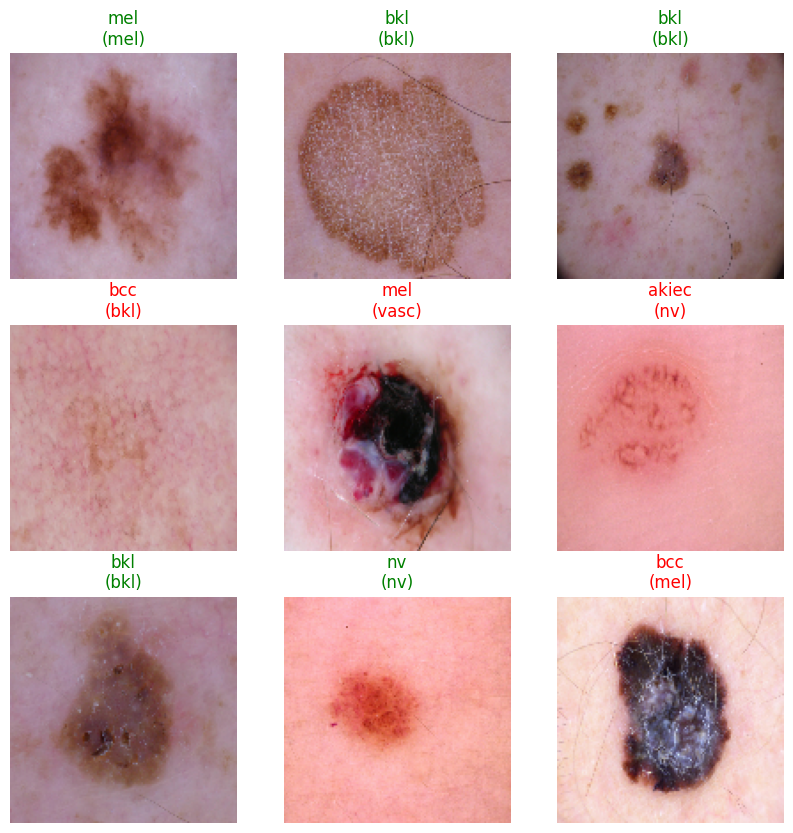

In [ ]:
from tensorflow.python.framework.c_api_util import ScopedTFImportGraphDefResults
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_2.predict(image_batch)

# Apply a sigmoid since our model returns logits
scores = [tf.nn.softmax(predictions[i]) for i in range(len(predictions))]
pred_class = [class_names[np.argmax(score)] for score in scores]
true_class = []
for i in label_batch:
  true_class.append(class_names[i])
  #print('Predictions:\n', pred_class[i])
#print('Labels:\n', class_names[i for i in label_batch])

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  ax.set_title("{}\n({})".format(pred_class[i], true_class[i]),
                     color=("green" if pred_class[i] == true_class[i] else "red"))
  plt.axis("off")